<a href="https://colab.research.google.com/github/aymuos/masters-practise-repo/blob/main/TSA_MonthlyCar_ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Group - 8**

----------------------------------------------------------


> CH24M548 - Mounika Chowdary Pamulapati

> CH24M571 - Soumya Mukherjee

> CH24M577 - Surya Kandala

-----------------------------------------------------------

Dataset used : monthly-car-sales.csv

-----------------------------------------------------------

# Steps we have followed :

1. **Importing the dataset**.
2. **Checking for Outliers** - Box Plot
3. **Cleaning the dataset**: No missing data observed.
4. **Split** the data into Training and Test dataset
5. Plot the ACF and PACF to observe the seasonality in the actual data.
6. **Stationarity Check**: Validated if the timeseries is stationary or not by performing ADF test. For ADF test if p < 0.05, then it says the timeseries is stationary.
7. **First Order Differencing**: Performing first order differencing to make the timeseries stationary.
8. Check if the **differenced data** is following **Gaussian Distribution** by plotting Bar graph.
9. Check the **variability of Variance** if its varying with **absolute time**.
10. **ACF and PACF**: Compute Auto Correlation and Partial correlation to understand the presence of MA and AR components.
11. **Power Spectral Density**: Frequency domain analysis of the timeseries data
12. **Models to forecast** the data
  1. Auto Arima with Seasonality (SARIMA)
  2. Facebook Prophet
  3. Holt-Winters Forecasting



Packages Required!

In [22]:
!pip install pandas seaborn matplotlib pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.8 MB/s eta 0:00:00


In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.signal import welch
from pmdarima import auto_arima
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Get Dataset

In [128]:
# Load the dataset from Drive

url='https://drive.google.com/file/d/1NqaXnCXgKhOQeLR0BI2cVeyL0GZQp_FN/view?usp=drive_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)

df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


**Outliers** in the dataset??

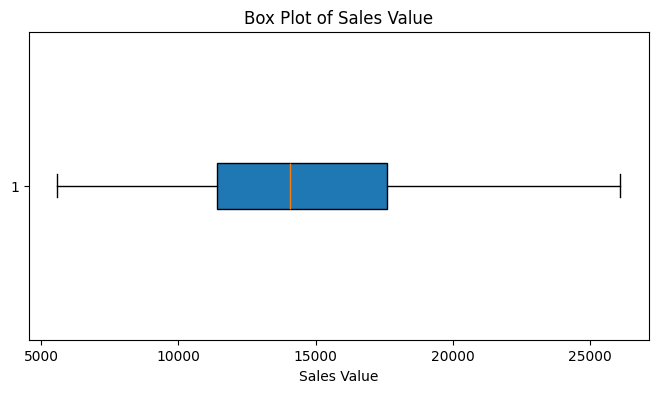

In [129]:
# checking if there are any outliers in the data using Box Plot

plt.figure(figsize=(8, 4))
plt.boxplot(df['Sales'],patch_artist = True, vert = 0)
plt.title('Box Plot of Sales Value')
plt.xlabel('Sales Value')
plt.show()

**Divide** the dataset into **Training and Test** in such a way that we have 80 percentage of car sales data in training dataset and the rest twenty percentage in test dataset

In [10]:
# Split the data into training and testing sets (80/20 split)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

# Save the training and testing sets to CSV files
train_data.to_csv('training.csv', index=False)
test_data.to_csv('test.csv', index=False)

train_data.head()

,Month,Sales
0,1960-01-01,6550
1,1960-02-01,8728
2,1960-03-01,12026
3,1960-04-01,14395
4,1960-05-01,14587


Plotting current data sales vs date

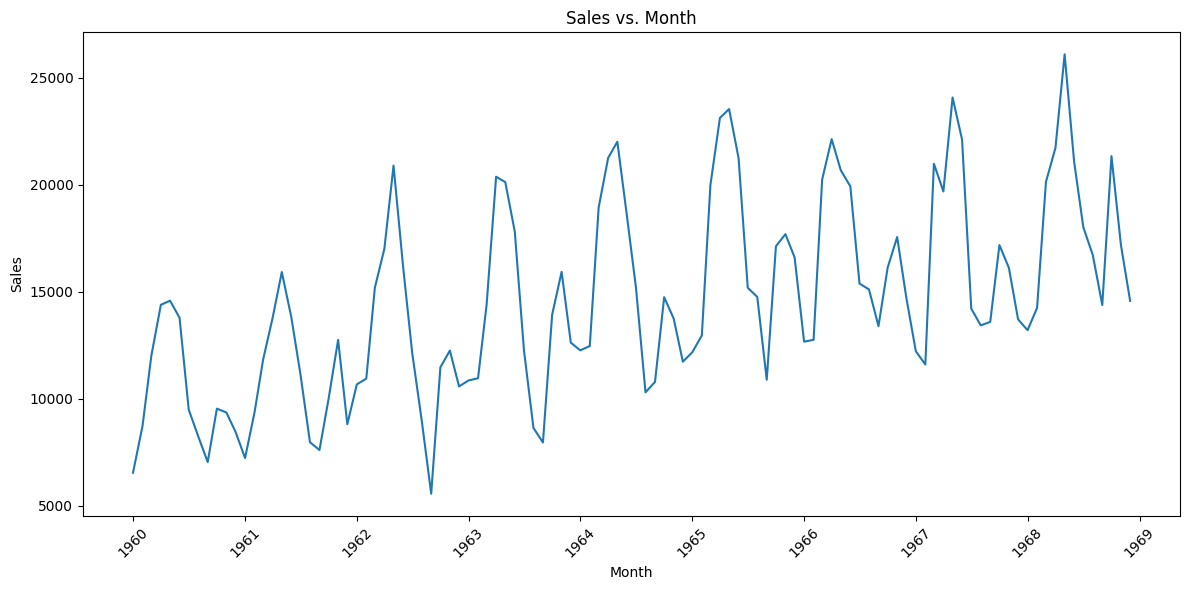

In [9]:
df['Month'] = pd.to_datetime(df['Month'])

plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.lineplot(x='Month', y='Sales', data=df)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales vs. Month')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

**Plot ACF and PACF** of the Sales data.

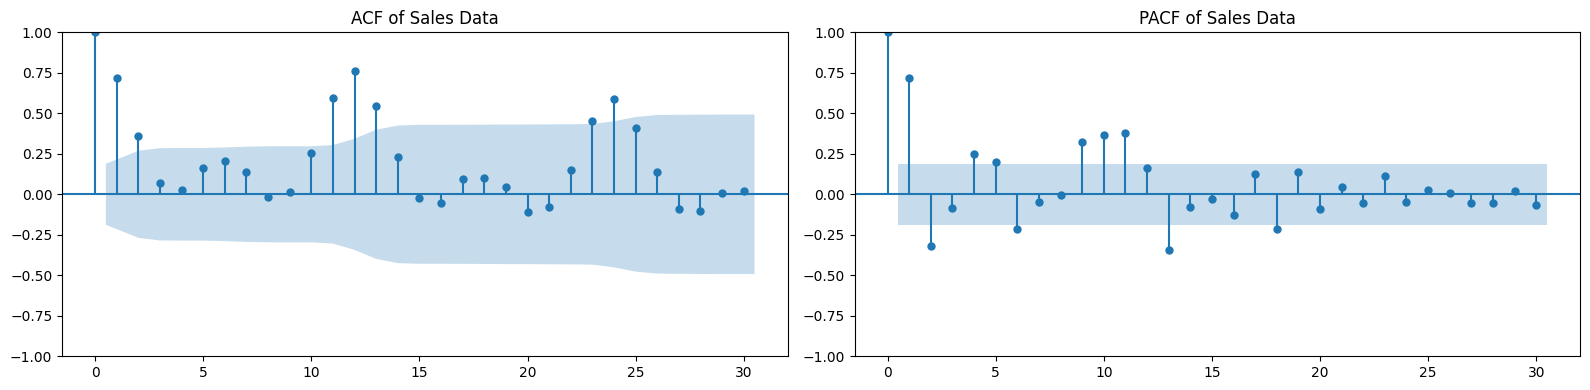

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(df['Sales'], lags=30, ax=axes[0])
axes[0].set_title('ACF of Sales Data')

plot_pacf(df['Sales'], lags=30, ax=axes[1])
axes[1].set_title('PACF of Sales Data')

plt.tight_layout()
plt.show()

Checking if the timeseries is **Stationary**

In [90]:
# Load the training data
train_data = pd.read_csv('training.csv')

train_data = train_data.set_index('Month')

def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('Augmented Dickey-Fuller Test:')
    results = {
        'statistic': result[0],
        'p_value': result[1],
        'No_of_Lags_Used': result[2],
        'observations_used': result[3],
        'is_stationary': result[1] < 0.05
    }
    for key, value in results.items():
        print(f'\t{key}: {value}')
    return results

def kpss_test(timeseries):
    result = kpss(timeseries, regression='c', nlags='auto') # 'c' for constant only
    print('\nKPSS Test:')
    results = {
        'statistic': result[0],
        'p_value': result[1],
        'No_of_Lags_Used': result[2],
        'observations_used': result[3],
        'is_stationary': result[1] > 0.05
    }
    for key, value in results.items():
        print(f'\t{key}: {value}')
    return results

# Perform ADF test
adf_results = adf_test(train_data['Sales'])

print('\n')

# Perform KPSS test
kpss_results = kpss_test(train_data['Sales'])

Augmented Dickey-Fuller Test:
	statistic: -1.3176992608750837
	p_value: 0.6210364838663147
	No_of_Lags_Used: 12
	observations_used: 73
	is_stationary: False



KPSS Test:
	statistic: 0.9397319611640241
	p_value: 0.01
	No_of_Lags_Used: 4
	observations_used: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
	is_stationary: False


Doing first order differencing to remove trends and make the timeseries stationary

In [132]:

train_data['Sales_diff'] = train_data['Sales'].diff()
train_data.dropna(inplace=True)

# Save the differenced data
train_data.to_csv('training_differenced.csv', index=True)

# Print info after differencing
train_data.head()

,Sales,Sales_diff
Month,,
1960-02-01,8728,2178.0
1960-03-01,12026,3298.0
1960-04-01,14395,2369.0
1960-05-01,14587,192.0
1960-06-01,13791,-796.0


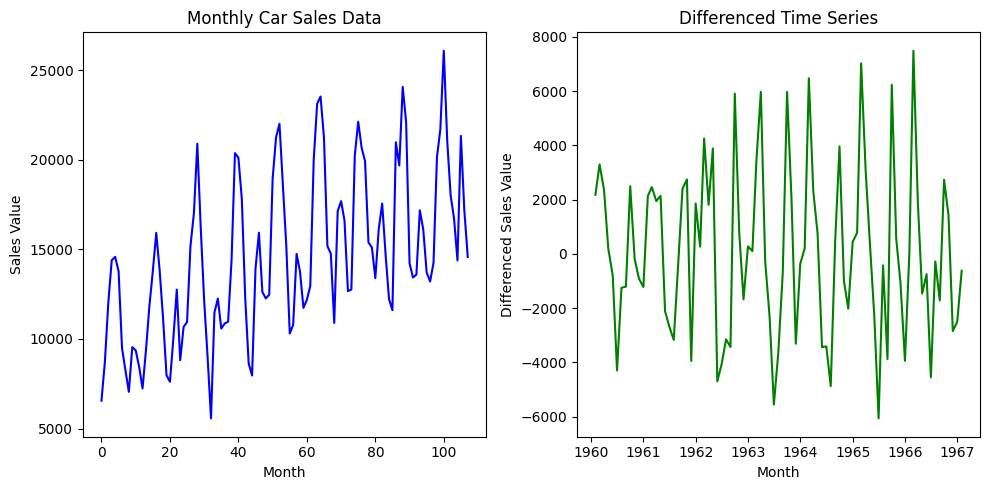

In [140]:
# Visualize the results
plt.figure(figsize=(10, 5))

# Original time series
plt.subplot(1, 2, 1)
plt.plot(df['Sales'], color = 'blue')
plt.title('Monthly Car Sales Data')
plt.xlabel('Month')
plt.ylabel('Sales Value')

# Differenced
plt.subplot(1, 2, 2)
plt.plot(train_data['Sales_diff'], color = 'green')
plt.title('Differenced Time Series')
plt.xlabel('Month')
plt.ylabel('Differenced Sales Value')

plt.tight_layout()
plt.show()

In [135]:
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('Augmented Dickey-Fuller Test:')
    results = {
        'statistic': result[0],
        'p_value': result[1],
        'No_of_Lags_Used': result[2],
        'observations_used': result[3],
        'is_stationary': result[1] < 0.05
    }
    for key, value in results.items():
        print(f'\t{key}: {value}')
    return results

def kpss_test(timeseries):
    result = kpss(timeseries, regression='c', nlags='auto') # 'c' for constant only
    print('\nKPSS Test:')
    results = {
        'statistic': result[0],
        'p_value': result[1],
        'No_of_Lags_Used': result[2],
        'observations_used': result[3],
        'is_stationary': result[1] > 0.05
    }
    for key, value in results.items():
        print(f'\t{key}: {value}')
    return results

# Perform ADF test
adf_results = adf_test(train_data['Sales_diff'])

print('\n')

# Perform KPSS test
kpss_results = kpss_test(train_data['Sales_diff'])

Augmented Dickey-Fuller Test:
	statistic: -2.94506962117876
	p_value: 0.040352449180491856
	No_of_Lags_Used: 12
	observations_used: 72
	is_stationary: True



KPSS Test:
	statistic: 0.04501509207107311
	p_value: 0.1
	No_of_Lags_Used: 0
	observations_used: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
	is_stationary: True


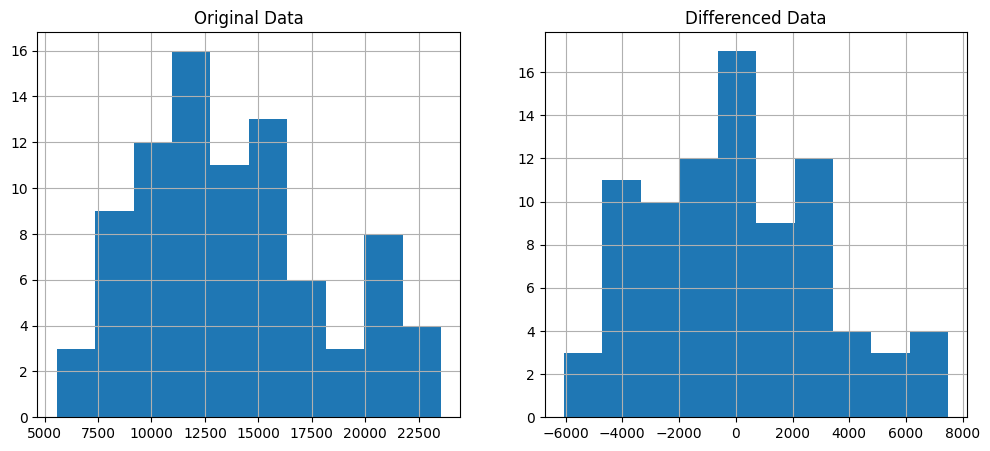

In [141]:
plt.figure(figsize=(12, 5))

## Histogram of the Original data

plt.subplot(1,2,1)
train_data['Sales'].dropna().hist()
plt.title("Original Data")

## Histogram of the Differenced data

plt.subplot(1,2,2)
train_data['Sales_diff'].dropna().hist()
plt.title("Differenced Data")
plt.show()


Text(0.5, 1.0, 'Rolling Standard Deviation Plot')

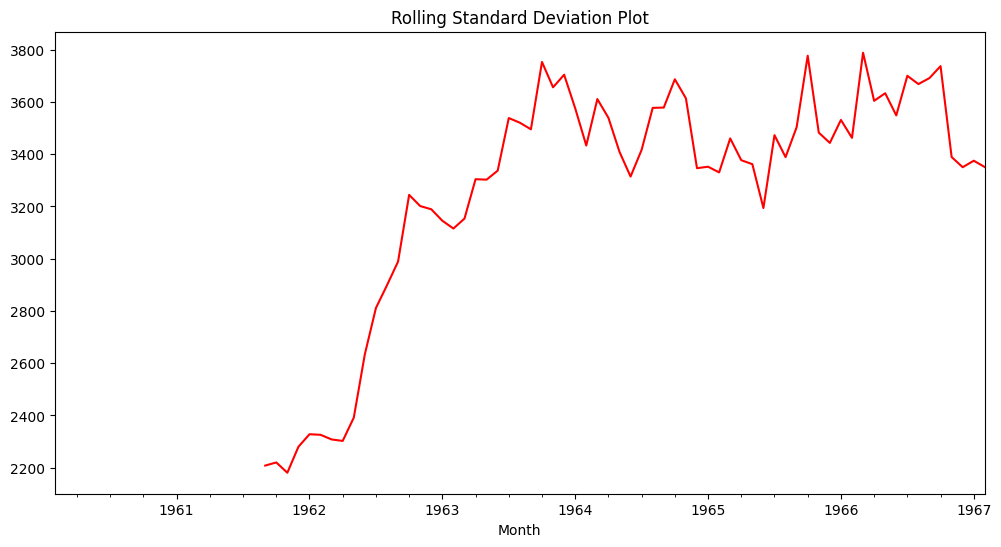

In [142]:
## Now lets check how is the variance. Is the differenced data stationary or not
plt.figure(figsize=(12, 6))
# add the 20 day rolling standard deviation:
train_data['Sales_diff'].dropna().rolling(window=20).std().plot(style='r')
# So the Variance changing over time.
plt.xlabel("Month")
plt.title("Rolling Standard Deviation Plot")

**Plot** the log-differenced data and its ACF and PACF graphs.

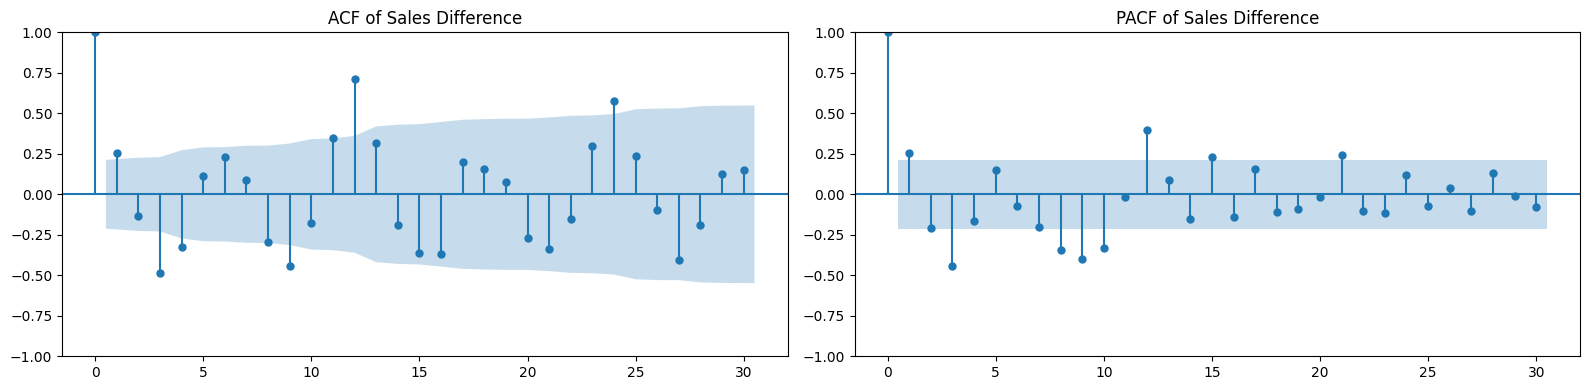

In [134]:

# Plot ACF and PACF of the log-differenced data
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(train_data['Sales_diff'], lags=30, ax=axes[0])
axes[0].set_title('ACF of Sales Difference')

plot_pacf(train_data['Sales_diff'], lags=30, ax=axes[1])
axes[1].set_title('PACF of Sales Difference')

plt.tight_layout()
plt.show()

**Power Spectral Density** plot to work on the frequency domain analysis of the timeseries. We are using **Welch method with Hamming window**

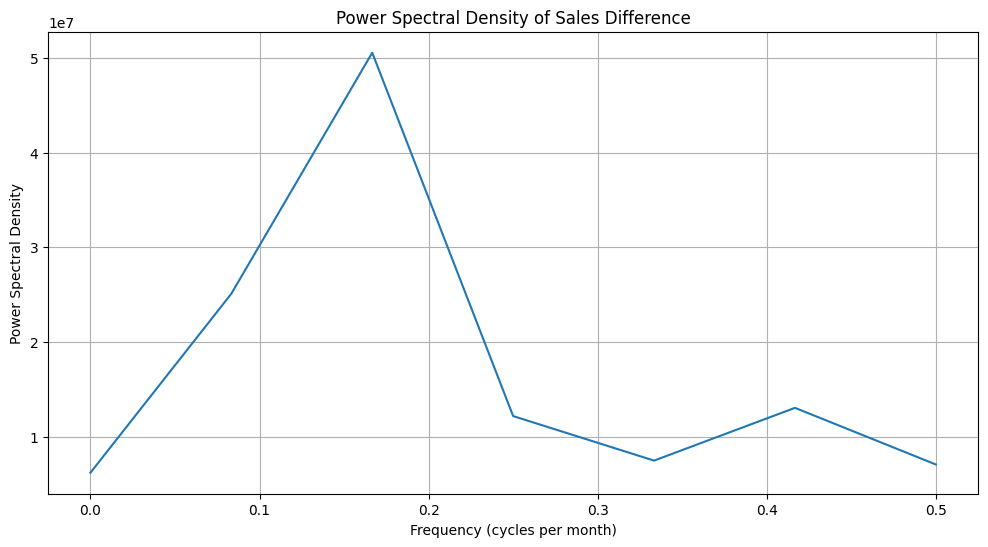

In [95]:
# Load the differenced data
train_data = pd.read_csv('training_differenced.csv', index_col='Month', parse_dates=True)

# Extract the 'Sales_log_differenced' data
sales_log_differenced = train_data['Sales_diff']

# Calculate the power spectral density using Welch's method with a Hamming window
frequencies, power_spectrum = welch(sales_log_differenced, window='hamming', nperseg=12)

# Plotting the Power Spectral Density
plt.figure(figsize=(12, 6))
plt.plot(frequencies, power_spectrum)
plt.xlabel('Frequency (cycles per month)')  # Assuming monthly data
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density of Sales Difference')
plt.grid(True)
plt.show()

Checking the best **Akaike's Information Criterion (AIC)** value using Auto Arima to predit the forecast

In [96]:

# Load the differenced data
train_data = pd.read_csv('training_differenced.csv', index_col='Month', parse_dates=True)

# Extract the 'Sales_log_differenced' data
sales_differenced = train_data['Sales_diff']

# Automatically find the best ARIMA model using auto_arima
# Suppress warnings from auto_arima
warnings.filterwarnings("ignore")

model = auto_arima(sales_differenced,
                   seasonal=True, m=12,  # Seasonal period is 12 (monthly data)
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=1289.689, Time=1.57 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1324.154, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1292.656, Time=0.15 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1290.120, Time=0.70 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1322.181, Time=0.03 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=1286.425, Time=3.69 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=1286.967, Time=2.87 sec
 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=1290.658, Time=4.16 sec
 ARIMA(1,0,2)(1,1,0)[12] intercept   : AIC=1291.254, Time=1.26 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=inf, Time=6.08 sec
 ARIMA(3,0,2)(1,1,0)[12] intercept   : AIC=1289.727, Time=1.42 sec
 ARIMA(2,0,3)(1,1,0)[12] intercept   : AIC=1288.709, Time=1.35 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept

Forcasting for ARIMA(2,0,2)(1,1,0)[12]

In [101]:
# Load the training and test data
original_data = pd.read_csv(url, index_col='Month', parse_dates=True)
train_data = pd.read_csv('training.csv', index_col='Month', parse_dates=True)
test_data = pd.read_csv('test.csv', index_col='Month', parse_dates=True)

# Fit the SARIMA model
model = SARIMAX(train_data['Sales'], order=(2, 0, 2), seasonal_order=(1, 1, 0, 12))
results = model.fit()

# Make predictions on the test data
predictions = results.get_forecast(steps=len(test_data))
predicted_mean = predictions.predicted_mean

print(results.summary())

predicted_mean.head()

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   86
Model:             SARIMAX(2, 0, 2)x(1, 1, [], 12)   Log Likelihood                -646.033
Date:                             Sun, 29 Dec 2024   AIC                           1304.066
Time:                                     14:08:43   BIC                           1317.890
Sample:                                 01-01-1960   HQIC                          1309.580
                                      - 02-01-1967                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2778      0.820      1.558      0.119      -0.329       2.885
ar.L2         -0.2934      

,predicted_mean
1967-03-01,20436.493588
1967-04-01,22958.770613
1967-05-01,22173.901054
1967-06-01,20930.284921
1967-07-01,15882.925890


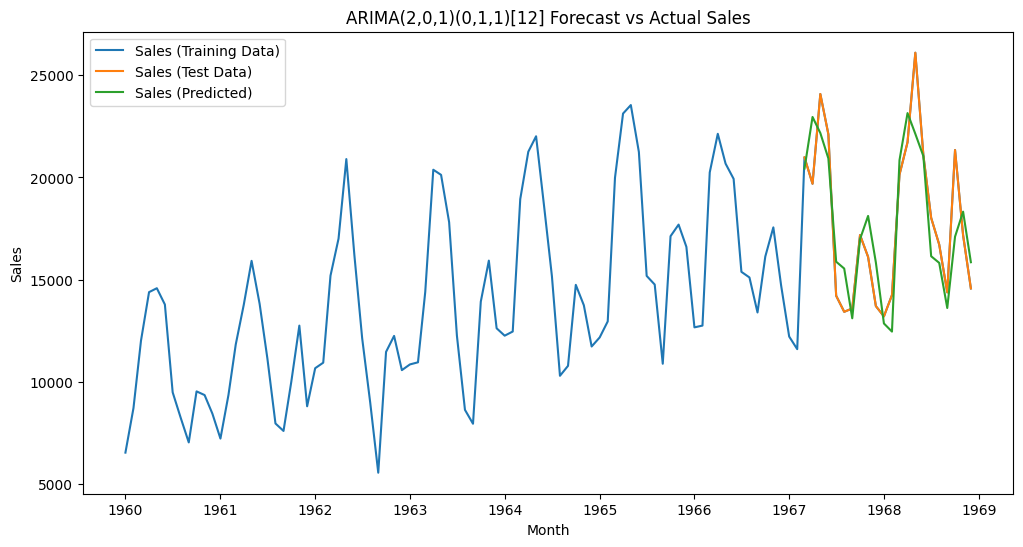

In [99]:
# Plot the test data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(original_data['Sales'], label='Sales (Training Data)')
plt.plot(test_data['Sales'], label='Sales (Test Data)')
plt.plot(predicted_mean, label='Sales (Predicted)')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('ARIMA(2,0,1)(0,1,1)[12] Forecast vs Actual Sales')
plt.legend()
plt.show()

Calculating the metrics

In [103]:
# Calculate MAE
mae = mean_absolute_error(test_data['Sales'], predicted_mean.values)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data['Sales'], predicted_mean.values))

# Calculate R-squared
r2 = r2_score(test_data['Sales'], predicted_mean.values)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(test_data['Sales'], predicted_mean.values)


# Print in a tabular form
print("-" * 30)
print("{:<10} {:<10}".format("Metric", "Value"))
print("-" * 30)
print("{:<10} {:<10.2f}".format("MAE", mae))
print("{:<10} {:<10.2f}".format("RMSE", rmse))
print("{:<10} {:<10.2f}".format("R-squared", r2))
print("{:<10} {:<10.2f}".format("MAPE", mape))
print("-" * 30)

------------------------------
Metric     Value     
------------------------------
MAE        1543.73   
RMSE       1899.84   
R-squared  0.74      
MAPE       8.62      
------------------------------


Trying Prophet

In [109]:
# Similar to how we did forecasting using sarima , we are trying to do the forecasting of sales vs date using facebook prophet

!pip install prophet

from prophet import Prophet

# Load the data
df = pd.read_csv(url)
df['Month'] = pd.to_datetime(df['Month'])
df = df.rename(columns={'Month': 'ds', 'Sales': 'y'})

# Split the data
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

# Initialize and fit the Prophet model
model = Prophet()
model.fit(train_df)

# Create future dataframe for forecasting
future = model.make_future_dataframe(periods=len(test_df), freq='MS')

# Make predictions
forecast = model.predict(future)

# Evaluate the model
y_true = test_df['y']
y_pred = forecast['yhat'][-len(test_df):]  # Select predictions for the test set


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphj4rzl_n/wzvfil73.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphj4rzl_n/nmrbptvx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13081', 'data', 'file=/tmp/tmphj4rzl_n/wzvfil73.json', 'init=/tmp/tmphj4rzl_n/nmrbptvx.json', 'output', 'file=/tmp/tmphj4rzl_n/prophet_model6m31m11o/prophet_model-20241229141425.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:14:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:14:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**Plot the Forecast**

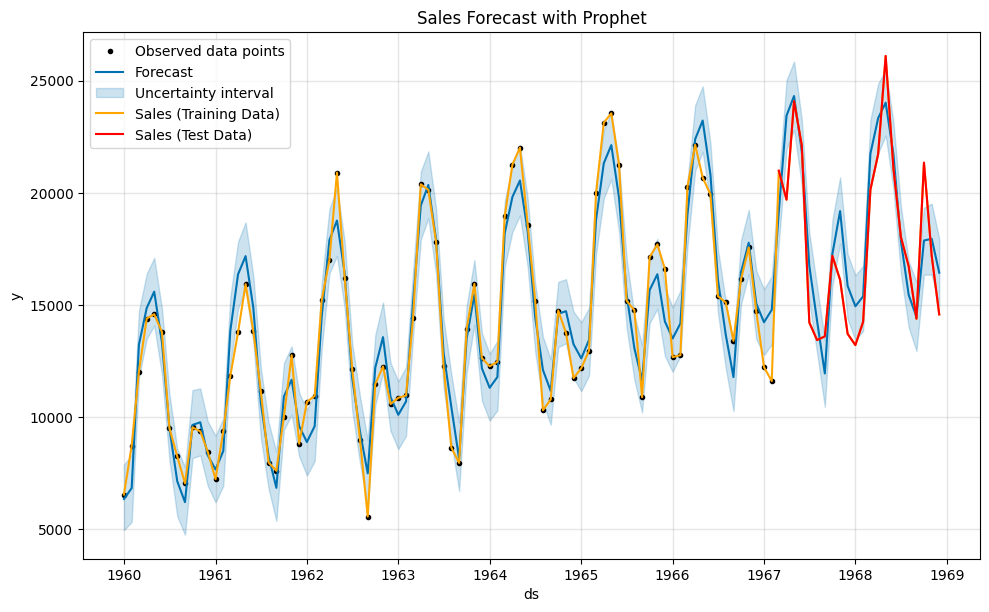

In [117]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.plot(original_data['Sales'], label='Sales (Training Data)', color='orange')
plt.plot(test_data['Sales'], label='Sales (Test Data)',color='red')
plt.title("Sales Forecast with Prophet")
plt.legend()
plt.show()



Plot the **Residuals**

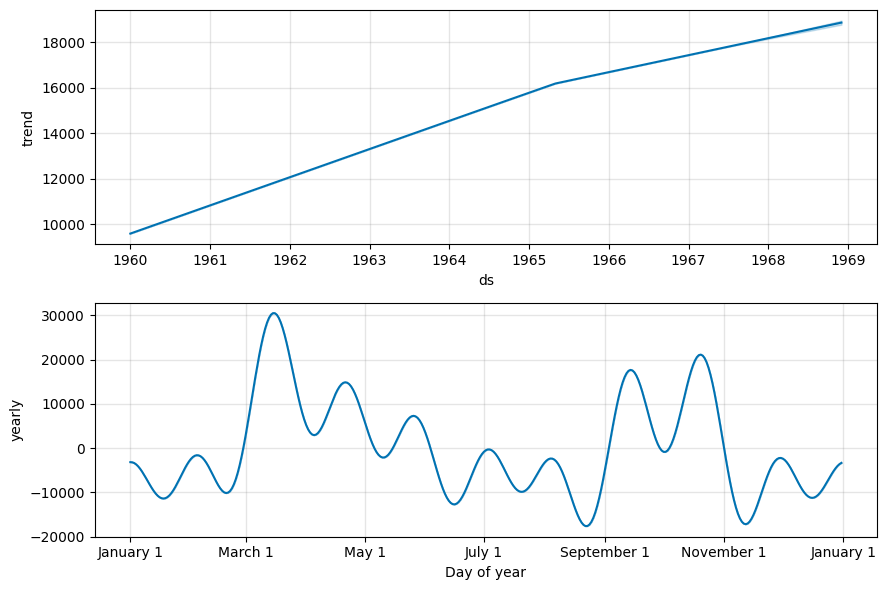

In [119]:
# Plot components
fig2 = model.plot_components(forecast)
plt.show()


Checking Metrics

In [120]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)


print("-" * 30)
print("{:<10} {:<10}".format("Metric", "Value"))
print("-" * 30)
print("{:<10} {:<10.2f}".format("MAE", mae))
print("{:<10} {:<10.2f}".format("RMSE", rmse))
print("{:<10} {:<10.2f}".format("R-squared", r2))
print("{:<10} {:<10.2f}".format("MAPE", mape))
print("-" * 30)


------------------------------
Metric     Value     
------------------------------
MAE        1491.83   
RMSE       1824.69   
R-squared  0.76      
MAPE       8.70      
------------------------------


Trying 3rd model - Holt-Winters Forecasting

In [124]:
# Load the original data
original_data = pd.read_csv(url, index_col='Month', parse_dates=True)


# Split data into training and testing sets
train_data, test_data = train_test_split(original_data, test_size=0.2, shuffle=False)

# Fit the Holt-Winters model
model = ExponentialSmoothing(train_data['Sales'], trend='add', seasonal='add', seasonal_periods=12)
results = model.fit()

# Forecast
n_steps = len(test_data)
forecast = results.forecast(steps=n_steps)
forecast_index = pd.date_range(start=train_data.index[-1] + pd.DateOffset(months=1), periods=n_steps, freq='MS')
forecasted_data = pd.DataFrame({'Sales': forecast}, index=forecast_index)


Plot the **Forecast**

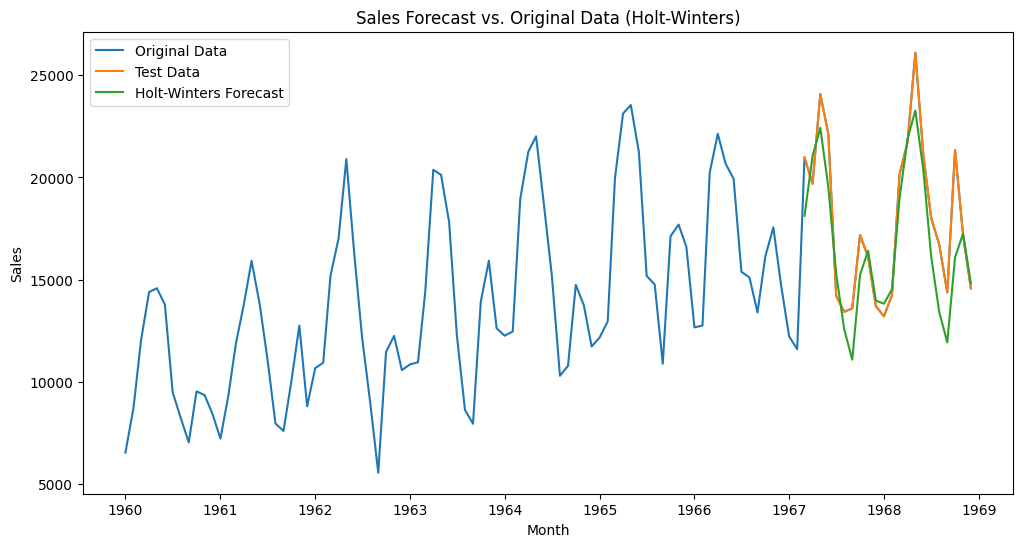

In [125]:

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(original_data['Sales'], label='Original Data')  # plot original data
plt.plot(test_data['Sales'], label='Test Data')  # Plot the test data
plt.plot(forecasted_data['Sales'], label='Holt-Winters Forecast')  # plot forecasted data
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales Forecast vs. Original Data (Holt-Winters)')
plt.legend()
plt.show()



Calculate **Metrics**

In [126]:
# Calculate Metrics
mae = mean_absolute_error(test_data['Sales'], forecasted_data['Sales'])
rmse = np.sqrt(mean_squared_error(test_data['Sales'], forecasted_data['Sales']))
r2 = r2_score(test_data['Sales'], forecasted_data['Sales'])
mape = mean_absolute_percentage_error(test_data['Sales'], forecasted_data['Sales'])

print("-" * 30)
print("{:<10} {:<10}".format("Metric", "Value"))
print("-" * 30)
print("{:<10} {:<10.2f}".format("MAE", mae))
print("{:<10} {:<10.2f}".format("RMSE", rmse))
print("{:<10} {:<10.2f}".format("R-squared", r2))
print("{:<10} {:<10.2f}".format("MAPE", mape))
print("-" * 30)

------------------------------
Metric     Value     
------------------------------
MAE        1564.52   
RMSE       2023.11   
R-squared  0.71      
MAPE       8.55      
------------------------------
